In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Importing all the necessary Libraries
import numpy as np 
import pandas as pd 
import pywt
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

import tensorflow
from tensorflow.keras.applications.inception_v3 import InceptionV3
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import keras
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.callbacks import History 
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense,Activation, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers import Input
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate
from keras.models import Model
from keras.datasets import mnist
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import Adam

np.random.seed(1000)

In [3]:
df=pd.read_csv('/content/drive/My Drive/Colab Notebooks/steadyteoaeLast10_4320Signals.csv')

In [4]:
df.head()

,Unnamed: 0,subject,session,ear,buffer,block,data_0,data_1,data_2,data_3,data_4,data_5,data_6,data_7,data_8,data_9,data_10,data_11,data_12,data_13,data_14,data_15,data_16,data_17,data_18,data_19,data_20,data_21,data_22,data_23,data_24,data_25,data_26,data_27,data_28,data_29,data_30,data_31,data_32,data_33,...,data_620,data_621,data_622,data_623,data_624,data_625,data_626,data_627,data_628,data_629,data_630,data_631,data_632,data_633,data_634,data_635,data_636,data_637,data_638,data_639,data_640,data_641,data_642,data_643,data_644,data_645,data_646,data_647,data_648,data_649,data_650,data_651,data_652,data_653,data_654,data_655,data_656,data_657,data_658,data_659
0,40,0,0,left,A,40,0.000062,0.000063,0.000065,0.000067,0.000069,0.000072,0.000074,0.000077,0.000078,0.000080,0.000081,0.000083,0.000084,0.000085,0.000085,0.000085,0.000085,0.000085,0.000084,0.000083,0.000082,0.000081,0.000081,0.000081,0.000080,0.000080,0.000080,0.000081,0.000081,0.000082,0.000083,0.000084,0.000084,0.000085,...,-0.000063,-0.000064,-0.000064,-0.000063,-0.000063,-0.000061,-0.000061,-0.000061,-0.000060,-0.000059,-0.000057,-0.000056,-0.000056,-0.000054,-0.000052,-0.000051,-0.000050,-0.000049,-0.000047,-0.000046,-0.000045,-0.000043,-0.000042,-0.000042,-0.000042,-0.000042,-0.000043,-0.000043,-0.000044,-0.000045,-0.000046,-0.000048,-0.000049,-0.000051,-0.000052,-0.000052,-0.000053,-0.000053,-0.000052,-0.000051
1,41,0,0,left,A,41,0.000063,0.000064,0.000065,0.000067,0.000070,0.000072,0.000075,0.000077,0.000079,0.000080,0.000081,0.000083,0.000084,0.000085,0.000085,0.000085,0.000085,0.000084,0.000083,0.000082,0.000082,0.000081,0.000081,0.000081,0.000080,0.000079,0.000079,0.000080,0.000081,0.000082,0.000083,0.000083,0.000084,0.000084,...,-0.000055,-0.000055,-0.000055,-0.000055,-0.000054,-0.000053,-0.000052,-0.000052,-0.000052,-0.000050,-0.000049,-0.000048,-0.000047,-0.000045,-0.000044,-0.000042,-0.000041,-0.000040,-0.000039,-0.000038,-0.000037,-0.000035,-0.000034,-0.000034,-0.000034,-0.000034,-0.000035,-0.000036,-0.000036,-0.000037,-0.000039,-0.000040,-0.000042,-0.000043,-0.000044,-0.000044,-0.000044,-0.000044,-0.000044,-0.000042
2,42,0,0,left,A,42,0.000065,0.000066,0.000067,0.000069,0.000071,0.000074,0.000077,0.000079,0.000081,0.000082,0.000083,0.000085,0.000086,0.000087,0.000087,0.000087,0.000087,0.000086,0.000085,0.000085,0.000084,0.000083,0.000083,0.000082,0.000081,0.000081,0.000081,0.000082,0.000083,0.000083,0.000084,0.000085,0.000086,0.000086,...,-0.000059,-0.000059,-0.000059,-0.000058,-0.000057,-0.000057,-0.000057,-0.000056,-0.000056,-0.000054,-0.000052,-0.000051,-0.000051,-0.000049,-0.000047,-0.000046,-0.000045,-0.000044,-0.000042,-0.000041,-0.000040,-0.000039,-0.000038,-0.000037,-0.000037,-0.000037,-0.000038,-0.000039,-0.000039,-0.000040,-0.000042,-0.000043,-0.000045,-0.000046,-0.000047,-0.000047,-0.000047,-0.000047,-0.000047,-0.000045
3,43,0,0,left,A,43,0.000065,0.000066,0.000067,0.000069,0.000071,0.000074,0.000077,0.000079,0.000080,0.000081,0.000083,0.000085,0.000086,0.000086,0.000086,0.000086,0.000086,0.000085,0.000084,0.000083,0.000082,0.000082,0.000081,0.000081,0.000080,0.000079,0.000079,0.000080,0.000081,0.000081,0.000082,0.000083,0.000083,0.000084,...,-0.000059,-0.000059,-0.000059,-0.000058,-0.000058,-0.000057,-0.000057,-0.000057,-0.000056,-0.000054,-0.000053,-0.000052,-0.000051,-0.000050,-0.000048,-0.000047,-0.000046,-0.000045,-0.000043,-0.000042,-0.000041,-0.000040,-0.000039,-0.000039,-0.000038,-0.000038,-0.000039,-0.000040,-0.000041,-0.000042,-0.000043,-0.000045,-0.000046,-0.000047,-0.000048,-0.000049,-0.000049,-0.000049,-0.000048,-0.000046
4,44,0,0,left,A,44,0.000061,0.000062,0.000063,0.000065,0.000067,0.000070,0.000072,0.000075,0.000076,0.000077,0.000078,0.000080,0.000081,0.000082,0.000082,0.000082,0.000082,0.000081,0.000080,0.000079,0.000078,0.000078,0.000078,0.000077,0.000076,0.000075,0.000075,0.000076,0.000077,0.000078,0.000079,0.000080,0.000080,0.000081,...,-0.000064,-0.000064,-0.000064,-0.000064,-0.000063,-0.000062,-0.000062,-0.000062,-0.0

In [5]:
#Checking for null values
print(df.info())
print("----Check if Data has any null values----")
print(df.isnull().sum())
if(df.isnull().values.any()==False):
    print("\nNo null Values in the dataset")
else:
    print("\ndataset has null values")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4320 entries, 0 to 4319
Columns: 666 entries, Unnamed: 0 to data_659
dtypes: float64(660), int64(4), object(2)
memory usage: 22.0+ MB
None
----Check if Data has any null values----
Unnamed: 0    0
subject       0
session       0
ear           0
buffer        0
             ..
data_655      0
data_656      0
data_657      0
data_658      0
data_659      0
Length: 666, dtype: int64

No null Values in the dataset


In [6]:
#Reading the csv file again and dropping unused columns
df_again = pd.read_csv('/content/drive/My Drive/Colab Notebooks/steadyteoaeLast10_4320Signals.csv')
df_again=df_again.drop(["session","ear","buffer","block"],axis=1)

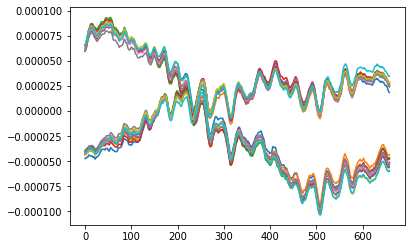

In [7]:
#View the signals in the dataset
for i in range(0,20):
    disp = df_again.iloc[i,2:661].values
    plt.plot(disp)
#10 consecutive signals are similar in a dataset while the next consecutive 10 are not.

Text(18, 97.9, '  98.05%')

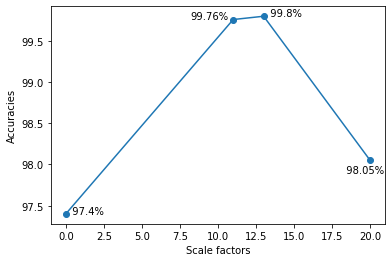

In [8]:
#Scale factor testing
import matplotlib.pyplot as plt
import seaborn as sns

x_is = [0,11,13,20]
y_is = [97.4,99.76,99.8,98.05]

plt.xlabel("Scale factors")
plt.ylabel("Accuracies")

plt.scatter(x_is,y_is)
plt.plot(x_is,y_is)
plt.annotate("  97.4%", (0, 97.4))
plt.annotate("99.76%", (8.2, 99.76))
plt.annotate("  99.8%", (13, 99.8))
plt.annotate("  98.05%", (18, 97.9))

In [9]:
#creating a dataFrame for the dataset
def subject0(subjectno, sessionno, earname, bufferid):
    dfu0=df.groupby(['subject', 'session', 'ear', 'buffer']).get_group((subjectno, sessionno, earname, bufferid)).iloc[-10:]
    return dfu0

x=subject0(34,0,'left','B')
x['subject'].iloc[0]
print(x.shape)
print(x)

(10, 666)
      Unnamed: 0  subject  session  ...  data_657  data_658  data_659
2730       30662       34        0  ...  0.000009  0.000009  0.000009
2731       30663       34        0  ...  0.000010  0.000010  0.000010
2732       30664       34        0  ...  0.000010  0.000010  0.000010
2733       30665       34        0  ...  0.000010  0.000010  0.000010
2734       30666       34        0  ...  0.000010  0.000010  0.000010
2735       30667       34        0  ...  0.000010  0.000010  0.000010
2736       30668       34        0  ...  0.000010  0.000010  0.000010
2737       30669       34        0  ...  0.000010  0.000010  0.000010
2738       30670       34        0  ...  0.000009  0.000008  0.000008
2739       30671       34        0  ...  0.000008  0.000008  0.000008

[10 rows x 666 columns]


In [10]:
#Creating Input and Labels DataFrame

allInputTEOAEsignalsAllSubjects = pd.DataFrame([])
allOutputLabelsAllSubjects = pd.DataFrame([])
for a in range(54):
    #print(a)
    df1 = pd.DataFrame([])
    b=[0,1]              # sessions 0 and 1
    c=['left','right']   # ears 
    d=['A','B']          # buffers
    
    allFeatures =  pd.DataFrame([])
    allInputFeatures =  pd.DataFrame([])
    outputLabel =  pd.DataFrame([])
    fftValues =  pd.DataFrame([])
    psdValues =  pd.DataFrame([])
    autocorrValues = pd.DataFrame([])
        
    for q,r,s in [(q,r,s) for q in b for r in c for s in d]:
        
        # df1 contains all the 80 TEOAE signals of subject a
        df1 = df1.append(subject0(a,q,r,s))
        allInputFeatures = df1.iloc[:,6:]
    
    allInputTEOAEsignalsAllSubjects = pd.concat([allInputTEOAEsignalsAllSubjects.reset_index(drop=True),
                                                 allInputFeatures.reset_index(drop=True)], axis=0)
    # the following gets you the class label <= subject no.[0,1,2,...,53]
    outputLabel = df1.iloc[:,1] 
    #print("OutputLabel:",outputLabel)
    #allOutputLabelsAllSubjects = allOutputLabelsAllSubjects.append(outputLabel)
    #append didn't work for output so using pd.cat instead
    allOutputLabelsAllSubjects = pd.concat([allOutputLabelsAllSubjects.reset_index(drop=True),
                                            outputLabel.reset_index(drop=True)], axis=0)
    #print(allInputTEOAEsignalsAllSubjects.shape)
    #print(allOutputLabelsAllSubjects.shape)


In [11]:
# save extracted dataframe locally
X=pd.DataFrame([])
y=pd.DataFrame([])
xsave = pd.DataFrame([])
ysave = pd.DataFrame([])
X = allInputTEOAEsignalsAllSubjects
y = allOutputLabelsAllSubjects
xsave = X
ysave = y
xsave.to_pickle('dataX.pkl')
ysave.to_pickle('labelY.pkl')
#a pkl file is a compressed form of the orginal csv. 
#Further the pkl file takes lesser storage space compared to the original csv 
#for eg., a csv file might take up 40 MB storage space but its pkl file would require only 1.5 MB storage space

In [12]:
#Load from pkl files
X = pd.read_pickle('dataX.pkl')
y = pd.read_pickle('labelY.pkl')

In [13]:
#Splitting 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [14]:
#Checking the dimensions of train and test array
print(np.asarray(X_train).shape)
print(np.asarray(X_test).shape)
print(np.asarray(y_train).shape)
print(np.asarray(y_test).shape)
labels_train = list(map(lambda x: int(x), np.asarray(y_train)))
print(np.asarray(labels_train).shape)

(3456, 660)
(864, 660)
(3456, 1)
(864, 1)
(3456,)


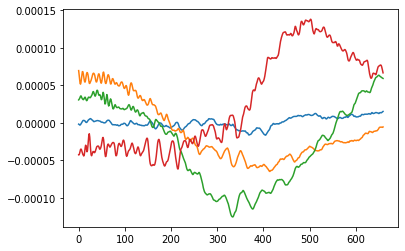

In [15]:
# Check if continuous waves are similar to each other in X_train
for i in range(1,5):
    X_disp = X_train.iloc[i,:].values
    plt.plot(X_disp)

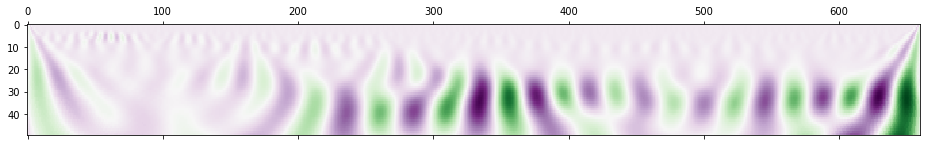

In [16]:
#scales = range(1,661)
scales = range(1,51)
waveletname = 'morl'
train_size = 3456
test_size= 864

#################################################
### plotting CWT of a single TEOAE signal  ######
#################################################
coeff, freq = pywt.cwt(X_train.iloc[3,:], scales, waveletname, 1)
plt.matshow(coeff,  cmap='PRGn', aspect='auto')
plt.show()

In [17]:
#CWT
scales = range(1,51)
waveletname = 'morl'
train_size = X_train.shape[0]
test_size= X_test.shape[0]

#########################################################
### creating a tensor to store CWT matrices of train egs#
#########################################################
train_data_cwt = np.ndarray(shape=(train_size, 50, 659)) 

for ii in range(0,train_size):
    # if ii % 50 == 0: #len(X_train) == 0:
    #     print(ii)
    signal = X_train.iloc[ii, :]
    coeff, freq = pywt.cwt(signal, scales, waveletname, 1)
    coeff_ = coeff[:,:659]
    train_data_cwt[ii, :, :] = coeff_
    #train_data_cwt[:, :, ii] = coeff_

###########################################################
### creating a tensor to store CWT matrices of test egs ###
###########################################################
test_data_cwt = np.ndarray(shape=(test_size, 50, 659))

for ii in range(0,test_size):
    # if ii % 50 == 0:
    #     print(ii)
    signal = X_test.iloc[ii, :]
    coeff, freq = pywt.cwt(signal, scales, waveletname, 1)
    coeff_ = coeff[:,:659]
    test_data_cwt[ii, :, :] = coeff_
    #test_data_cwt[:, :, ii] = coeff_

###########################################################
### convert the labels from float to int of train and test egs
###########################################################
labels_train = list(map(lambda x: int(x), np.asarray(y_train)))
labels_test = list(map(lambda x: int(x), np.asarray(y_test)))

###########################################################
### putting all the train and test CWT data             ###
###########################################################
x_train = train_data_cwt
y_train = list(labels_train[:train_size])
x_test = test_data_cwt
y_test = list(labels_test[:test_size])

In [18]:
#Convert the labels to array
y_test_np = np.asarray(y_test)
y_train_np = np.asarray(y_train)

In [19]:
#Printing shapes
print(np.asarray(x_train).shape)
print(np.asarray(x_test).shape)
print(np.asarray(y_train).shape)
print(np.asarray(y_test).shape)
print(len(x_train))
print(len(x_test))

(3456, 50, 659)
(864, 50, 659)
(3456,)
(864,)
3456
864


In [20]:
# save numpy array
np.save('x_train_CNN', x_train)
np.save('x_test_CNN', x_test)
np.save('y_test_CNN', y_test_np)
np.save('y_train_CNN', y_train_np)

In [21]:
#load data
x_train = np.load('x_train_CNN.npy')
x_test = np.load('x_test_CNN.npy')
y_train_np = np.load('y_train_CNN.npy')
y_test_np = np.load('y_test_CNN.npy')

In [22]:
#AlexNet:

model = AlexNet = Sequential()

#1st Convolutional Layer
AlexNet.add(Conv2D(filters=96, input_shape=(50,660,3), kernel_size=(11,11), strides=(4,4), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#2nd Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#3rd Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#4th Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#5th Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#Passing it to a Fully Connected layer
AlexNet.add(Flatten())

In [23]:
#AlexNet
num_classes=54
x_train_cnn = x_train.reshape(3456,50,659,1)#len(x_train),img_x, img_y, img_z)
x_test_cnn = x_test.reshape(864,50,659,1)#len(x_test),img_x, img_y, img_z)
rgb_train = np.repeat(x_train_cnn, 3, -1)
rgb_test = np.repeat(x_test_cnn,3,-1)

In [24]:
#Compile the Model
AlexNet.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [25]:
#obtain the flattened output for training
features_xtrain=AlexNet.predict(rgb_train) #training
features_xtrain.shape

(3456, 10752)

In [26]:
#Flattened output for Testing
features_xtest=AlexNet.predict(rgb_test) #testing
features_xtest.shape

(864, 10752)

In [27]:
# performing PCA on the flattened array

scaler = StandardScaler()
scaler.fit(features_xtrain)

features_xtrain = scaler.transform(features_xtrain)
features_xtest = scaler.transform(features_xtest)

pca = PCA(.95)  #using 95% of the variance in the model.

pca.fit(features_xtrain)

features_xtrain = pca.transform(features_xtrain)
features_xtest = pca.transform(features_xtest)

In [28]:
 #SVM classifier

svm=SVC()
svm.fit(features_xtrain,y_train_np)

#training accuracy
acc_svm_train=round(svm.score(features_xtrain,y_train_np)*100,2)
print("Training Accuracy:",acc_svm_train)

#testing accuracy
acc_svm_test=round(svm.score(features_xtest,y_test_np)*100,2)
print("Testing accuracy:",acc_svm_test)

Training Accuracy: 97.63
Testing accuracy: 96.18


In [29]:
# MLP classification
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,150,100), max_iter=50, alpha=0.0001,
                     solver='adam', verbose=10,  random_state=0,tol=0.000001)
mlp_clf.fit(features_xtrain, y_train_np)

pred_test = mlp_clf.predict(features_xtest) #testing accuracy
accuracy_score(y_test_np, pred_test)*100

Iteration 1, loss = 3.92930277
Iteration 2, loss = 1.50940738
Iteration 3, loss = 0.48390894
Iteration 4, loss = 0.18716786
Iteration 5, loss = 0.09837190
Iteration 6, loss = 0.05906338
Iteration 7, loss = 0.03713580
Iteration 8, loss = 0.02427681
Iteration 9, loss = 0.01616169
Iteration 10, loss = 0.01176992
Iteration 11, loss = 0.00933163
Iteration 12, loss = 0.00764906
Iteration 13, loss = 0.00626224
Iteration 14, loss = 0.00532035
Iteration 15, loss = 0.00453676
Iteration 16, loss = 0.00387568
Iteration 17, loss = 0.00342884
Iteration 18, loss = 0.00308512
Iteration 19, loss = 0.00274216
Iteration 20, loss = 0.00247546
Iteration 21, loss = 0.00224017
Iteration 22, loss = 0.00204667
Iteration 23, loss = 0.00188065
Iteration 24, loss = 0.00174544
Iteration 25, loss = 0.00161138
Iteration 26, loss = 0.00148104
Iteration 27, loss = 0.00138207
Iteration 28, loss = 0.00128504
Iteration 29, loss = 0.00120361
Iteration 30, loss = 0.00113224
Iteration 31, loss = 0.00106683
Iteration 32, los

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


100.0

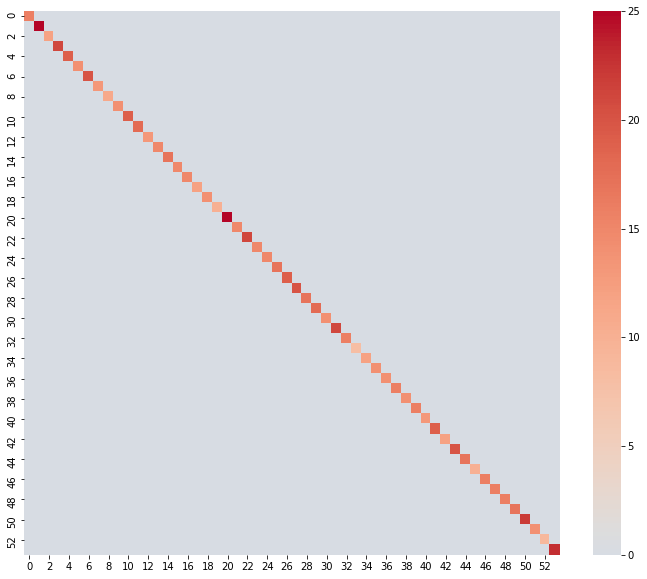

In [30]:
# Plotting the Confusion matrix
cm = confusion_matrix(y_test_np, pred_test)
plt.figure(figsize=(12,10))
sns.heatmap(cm, center=True, cmap='coolwarm')
plt.show()

In [32]:
# KNN algorithm 

knn = KNeighborsClassifier(n_neighbors=5) 
knn.fit(features_xtrain, y_train_np) 
pred_test = knn.predict(features_xtest) #testing accuracy
accuracy_score(y_test_np, pred_test)*100

100.0

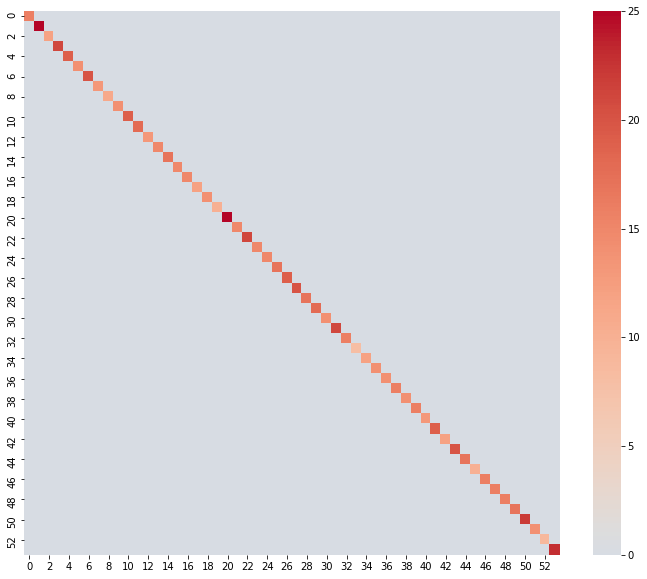

In [33]:
cm = confusion_matrix(y_test_np, pred_test)

plt.figure(figsize=(12,10))
sns.heatmap(cm, center=True, cmap='coolwarm')
plt.show()

In [34]:
# XGBoost classifier

from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(features_xtrain, y_train_np)
pred_test = model.predict(features_xtest) #testing accuracy
accuracy_score(y_test_np, pred_test)*100

99.65277777777779

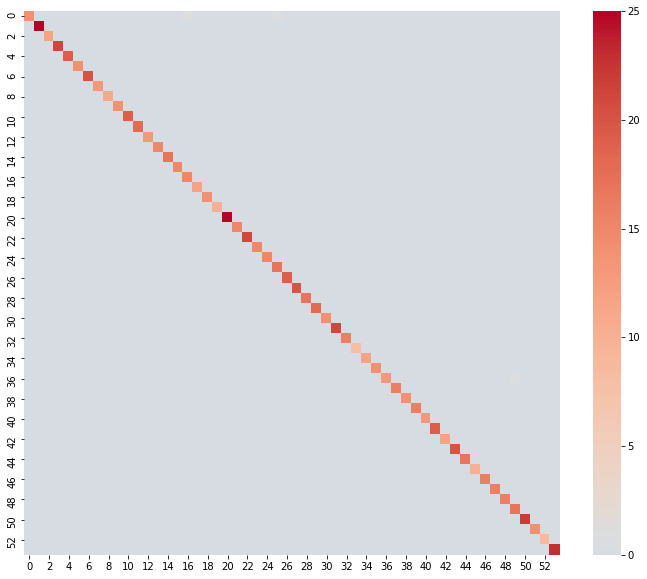

In [35]:
cm = confusion_matrix(y_test_np, pred_test)

plt.figure(figsize=(12,10))
sns.heatmap(cm, center=True, cmap='coolwarm')
plt.show()